plot facebook data in a 2D Histogramm

In [1]:
# takes around 3mins repending on number of points
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
import utm

# read
df = pd.read_csv("pop_ger.csv", sep = ",", names = ["y","x","weight"], dtype = np.float64, skiprows = 1)

# carefull this is about square
LONMIN = 51.32570534890512
LATMIN =  12.347111924747685

LONMAX = 51.35165731753352
LATMAX = 12.397580367482496

print("selecting the relevant rows...")
# select rows that are inside of the bounding box
df = df[(df.x >= LATMIN) & (df.x <= LATMAX)]
df = df[(df.y >= LONMIN) & (df.y <= LONMAX)]

print("converting to numpy...")
# convert to numpy
x = df["x"].tolist()
y = df["y"].tolist()
weight = df["weight"].tolist()

selecting the relevant rows...
converting to numpy...


plotting...


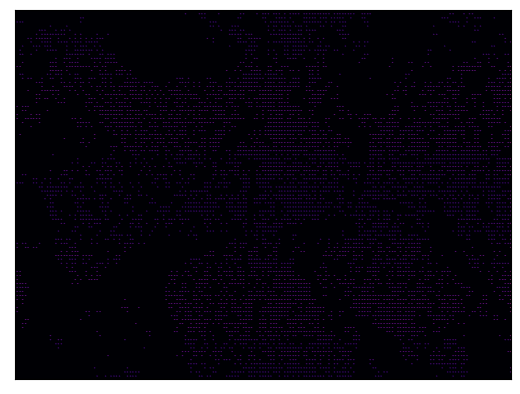

In [2]:
BINS = 1000
BLUR = 1

print("plotting...")

fig, ax = plt.subplots()
data = np.histogram2d(x, y, weights = weight, bins=BINS)[0]
data = gaussian_filter(data, sigma=BLUR)
plt.pcolormesh(data.T, cmap='inferno', shading='gouraud')
ax.set_xticks([])
ax.set_yticks([])
fig.canvas.draw()

Relating everything back to how good each place is connected

Metrics:

- Stop Density
- "Mobility Score"

Number of Inhabitants:  28118.76501561555


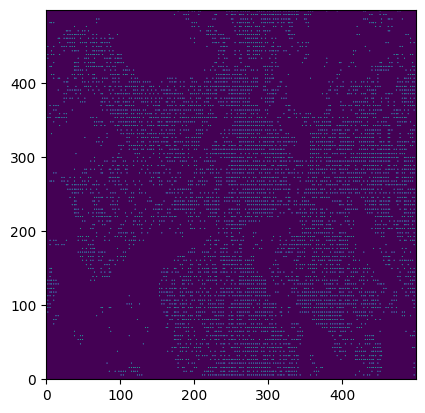

In [3]:

import math as m
import matplotlib.pyplot as plt


GRIDSIZE = 500

# calculate delta as the range of all possible coorinates. Every coordinate falls in this range
LONDELTA = LONMAX - LONMIN
LATDELTA = LATMAX - LATMIN


POPULATIONGRID = [[0 for i in range(GRIDSIZE)] for j in range (GRIDSIZE)]


l = []
def getindices(lat, lon):


    xind = m.floor(((lat-LATMIN) / (LATMAX - LATMIN)) * GRIDSIZE) # data normalisation to be in the range of 0 - 99
    yind = m.floor(((lon-LONMIN) / (LONMAX - LONMIN)) * GRIDSIZE)

    return [xind,yind]

for x1, y1, w1 in zip(x,y, weight):
    xind, yind = getindices(x1,y1)
    POPULATIONGRID[yind][xind] += w1

# sanity check

print("Number of Inhabitants: ", np.sum(POPULATIONGRID))

plt.imshow(POPULATIONGRID, interpolation = None, origin = "lower")
plt.show()



Read in Neighbours and put them on the same grid

In [4]:
# calculate some stats
import math as m
import haversine as hs 

diagonal = hs.haversine((LATMAX, LONMAX), (LATMIN, LONMIN))
side = diagonal / m.sqrt(2)

# Maßstab berechnen
onepxlength = side / GRIDSIZE # length of one pixel in grid in KM

print("One Pixel in KM:", onepxlength)



print("Square side Length in KM: ", side)

One Pixel in KM: 0.008881206673487052
Square side Length in KM:  4.440603336743526


0.2


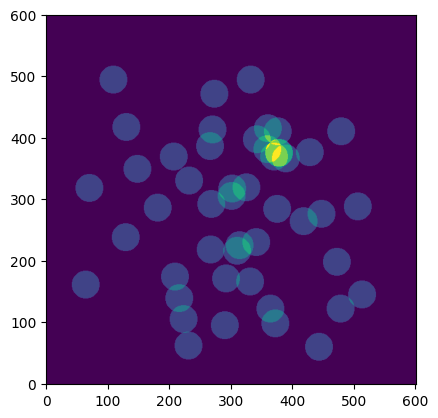

In [5]:
import json
from utils import load_stops_as_dict
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d
import numpy as np

all_stops = load_stops_as_dict()

f = open("lvb_auswertung/neighbours_1.json")
nb = json.load(f)

def create_stopsgrid_and_convolve(r_orig = 0.2):

    

    STOPSGRID = [[0 for i in range(GRIDSIZE)] for j in range (GRIDSIZE)] # create grid thats 0-99

    for key_stop, nb_list in nb.items():


        w = len(nb_list)
        lat, lon = all_stops[key_stop]

        # convert directly to grid indices 
        xind, yind = getindices(lon, lat)


        # not all stops are inside of the bounding box created earlier
        if (0 <= yind < GRIDSIZE) and (0 <= xind < GRIDSIZE):
            STOPSGRID[yind][xind] += 1

            # TODO use weighted stops
            # STOPSGRID[yind][xind] += 1

    # blur the stops because they are "reachable" in a circle around them
    #BLURREDSTOPSGRID = gaussian_filter(np.array(STOPSGRID), sigma=0)

    # the same can be done with a convolution filter
    # first create a circluar filter
    # then convolve it over every pixel in the image
    # pixels that contain (at least) one stop will be turned into a circle
    # https://stackoverflow.com/questions/49330080/numpy-2d-array-selecting-indices-in-a-circle



    # TODO this has to be adapted to the actual selection size. Otherwise the stop radius is too wide
    cx = 30.
    cy = 30.
    r = r_orig/onepxlength

    print(r_orig)

    fx = np.arange(0, 4.5 * r) 
    fy = np.arange(0, 4.5 * r)
    farr = np.zeros((fy.size, fx.size))

    mask = (fx[np.newaxis,:]-cx)**2 + (fy[:,np.newaxis]-cy)**2 < r**2
    farr[mask] = 1.

    kernel = farr
    CONVOLVEDSTOPSGRID = convolve2d(STOPSGRID, kernel)

    return CONVOLVEDSTOPSGRID

if __name__ == "__main__":
    CONVOLVEDSTOPSGRID = create_stopsgrid_and_convolve()
    plt.imshow(CONVOLVEDSTOPSGRID, interpolation = None, origin = "lower")
    plt.show()

Analyzing both grids
- how many people live withing x meters of a bus stop
- how many people 

In [6]:

numstops = 2

def analyze_grids(CONVOLVEDSTOPSGRID):
    populationsum = 0
    for x, poprow in enumerate(POPULATIONGRID):
        for y, poppixle in enumerate(poprow):
            if CONVOLVEDSTOPSGRID[x][y] >= numstops:
                populationsum += poppixle

    num = m.floor(populationsum)
    
    return num




In [7]:
# generate function people(distance)

SAMPLES = 3
START_RADIUS = 0.1 # in KM
STOP_RADIUS = 1 # in KM

radius_list = np.linspace(START_RADIUS, STOP_RADIUS, SAMPLES)

all_x = []
all_y = []

for i in tqdm(radius_list):
    all_y.append(analyze_grids(create_stopsgrid_and_convolve(i)))
    all_x.append(i)


print(all_x)
print(all_y)

plt.plot(all_x, all_y)
plt.show()
    
    




  0%|          | 0/3 [00:00<?, ?it/s]

0.1


 33%|███▎      | 1/3 [00:02<00:04,  2.32s/it]

0.55


 67%|██████▋   | 2/3 [01:52<01:05, 65.83s/it]